In [58]:
import requests as rq
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from fastf1 import get_events_remaining
import pandas as pd

In [59]:
def initialize_chrome_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    return driver

In [60]:
def get_next_race_content():
    driver = initialize_chrome_driver()
    url = "https://www.formula1.com/en/racing/2024"
    driver.get(url)
    html = driver.page_source
    soup = bs(html, 'html.parser')
    content_divs = soup.find_all('div', attrs={'class': 'f1-container'})
    return content_divs    

In [61]:
def get_specific_div_content():
    content_div = get_next_race_content()
    country_event = get_events_remaining().iloc[0].Country
    for div in content_div:
        if div.find('fieldset') and country_event in div.text:
            event_content = div
            break
    return event_content

In [62]:
def get_date_events():
    event_content = get_specific_div_content()
    paragraphs = event_content.find_all('p', class_='f1-text')
    titles = event_content.find_all('p', class_='f1-heading')
    event_dates = []
    event_titles = []
    for p in paragraphs:
        if 'font-normal' in p.get('class', []) and 'uppercase' in p.get('class', []):
            event_dates.append(p.get_text())

    for p in titles:
        if 'uppercase' in p.get('class', []):
            event_titles.append(p.get_text())
    return event_dates, event_titles


In [63]:
def create_event_dataframe():
    dates, titles = get_date_events()
    event_data = []
    
    for i in range(len(titles)):
        event_data.append({
            'Evento': titles[i],
            'Dia': dates[i * 2],
            'Horário': dates[i * 2 + 1]
        })

    df = pd.DataFrame(event_data)

    return df

In [64]:
create_event_dataframe()

,Evento,Dia,Horário
0,Practice 1,Fri,12:30 - 13:30
1,Practice 2,Fri,16:00 - 17:00
2,Practice 3,Sat,11:30 - 12:30
3,Qualifying,Sat,15:00 - 16:00
4,Race,Sun,15:00


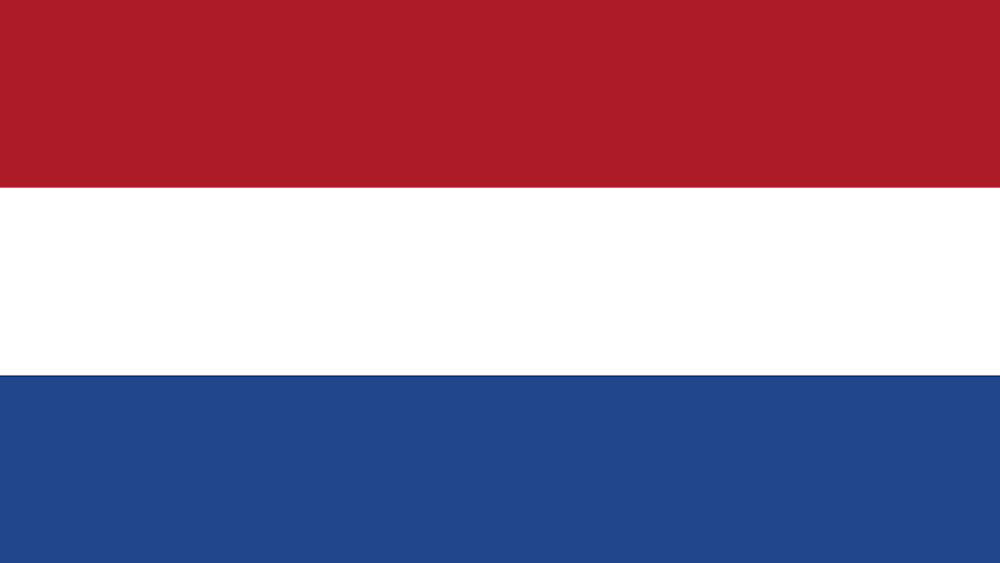

In [21]:
from io import BytesIO
from PIL import Image
from IPython.display import display

img_tag = event_content.find('img', alt=country_event)
img_url = img_tag['src']
response = rq.get(img_url)
img = Image.open(BytesIO(response.content))
display(img)